# Image Captioning with Multimodal 11B LLaMA 3.2-Vision (Hugging Face)

The Hugging Face version of **11B LLaMA 3.2 Vision** has weights in `safetensors` format which integrates with other tools and it comes with several other necessary files required for practical use.

This notebook shows how the Hugging Face model is loaded and runs captioning tests. Unfortunately, this model proved very difficult to work with as captions contained a repetitive security preamble that proved hard to eliminate. Some examples of methods to control the preamble are explored.

Eventually, this model was dropped in favor of the **Ollama** version which produced great results out of the box. It is highly recommended that you use Ollama instead of the Hugging Face model if you want to be up and running quickly. See the companion Notebook to look at loand Ollama and running Image Captioning with it. Ollama also runs faster as it is quantized and fits fully loaded into many more consumer GPUs as it is less than half the size of the Hugging Face model.

#### Verify GPU

In [1]:
import torch; print("torch", torch.__version__, "| cuda:", torch.cuda.is_available())

torch 2.5.1+cu121 | cuda: True


## Load the model
Use flexible loading methods to adapt to varous platforms

In [ ]:
### LOAD THE MODEL

# ---------- ENV & imports (env BEFORE torch/transformers) ----------
import os
# Windows ignores expandable_segments; keep a sane split size
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "max_split_size_mb:256")  # ← simpler, effective on Windows
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")                   # ← optional: quieter logs

from IPython.display import display
import gc, time, threading
from PIL import Image
import pynvml as nv
import requests
import torch

from transformers import (
    AutoProcessor,
    MllamaForConditionalGeneration,
    TextIteratorStreamer,
)

# Try to use 4-bit on platforms where bitsandbytes works
USE_4BIT = True
try:
    if USE_4BIT:
        from transformers import BitsAndBytesConfig
        _ = __import__("bitsandbytes")  # raises if not installed
    else:
        BitsAndBytesConfig = None
except Exception:
    BitsAndBytesConfig = None
    USE_4BIT = False
    print("[info] bitsandbytes not available; will use fp16 fallback.")

# ---------- hygiene ----------
def flush_cuda():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.reset_peak_memory_stats()

# Don't flush if you're reusing the same model; harmless here once at start
flush_cuda()
print(f"After flush: alloc={torch.cuda.memory_allocated()/1e9:.2f} GB"
      f"reserved={torch.cuda.memory_reserved()/1e9:.2f} GB")

# ---------- config ----------
model_id = "meta-llama/Llama-3.2-11B-Vision"

# Show cache locations
try:
    from huggingface_hub import scan_cache_dir
    cache = scan_cache_dir()
    for repo in cache.repos:
        if repo.repo_id == model_id:
            print("Repo cache path:", repo.repo_path)
            for rev in repo.revisions:
                print("Snapshot path:", rev.snapshot_path)
except Exception:
    pass

# ---------- load processor & model (guard against reloading) ----------
if "model" in globals() and getattr(model, "config", None) is not None:
    print("[reuse] Model already loaded on", next(model.parameters()).device)  # ← prevents second-load OOM
else:
    processor = AutoProcessor.from_pretrained(model_id)

    load_kwargs = dict(attn_implementation="eager")  # safest on Windows
    # load_kwargs = dict(attn_implementation="sdpa")  # try later if you want cache+speed and it’s stable

    if USE_4BIT:
        # Recommended 4-bit knobs
        bnb = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,       # ← set common bnb knob: double-quant
            bnb_4bit_quant_type="nf4",            # ←set common bnb knob: nf4
        )
        model = MllamaForConditionalGeneration.from_pretrained(
            model_id,
            device_map="auto",
            quantization_config=bnb,
            **load_kwargs,
        )
        print("[ok] Loaded 4-bit quantized model.")
    else:
        try:
            model = MllamaForConditionalGeneration.from_pretrained(
                model_id,
                torch_dtype=torch.float16,
                device_map={"": 0},
                low_cpu_mem_usage=True,
                **load_kwargs,
            )
            print("[ok] Loaded fp16 model on cuda:0")
        except Exception as e:
            print("[warn] OOM or placement issue on cuda:0:", e)
            # Hint auto-placement to favor GPU while avoiding CPU offload
            model = MllamaForConditionalGeneration.from_pretrained(
                model_id,
                torch_dtype=torch.float16,
                device_map="auto",
                max_memory={0: "23GiB", "cpu": "64GiB"},  # ← nudge away from CPU if the GPU can cover it
                low_cpu_mem_usage=True,
                **load_kwargs,
            )
            print("[ok] Loaded fp16 model with device_map=auto")

    model.eval()
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    # torch.set_float32_matmul_precision("high")  # ← optional duplicate to the above

# ---------- show device map ----------
dm = getattr(model, "hf_device_map", None)
if dm:
    from collections import Counter
    print("Device map counts:", Counter(dm.values()))
    cpu_parts = [k for k,v in dm.items() if v == "cpu"]
    if cpu_parts:
        print("WARNING: some modules on CPU (sample):", cpu_parts[:10])

## Test the model

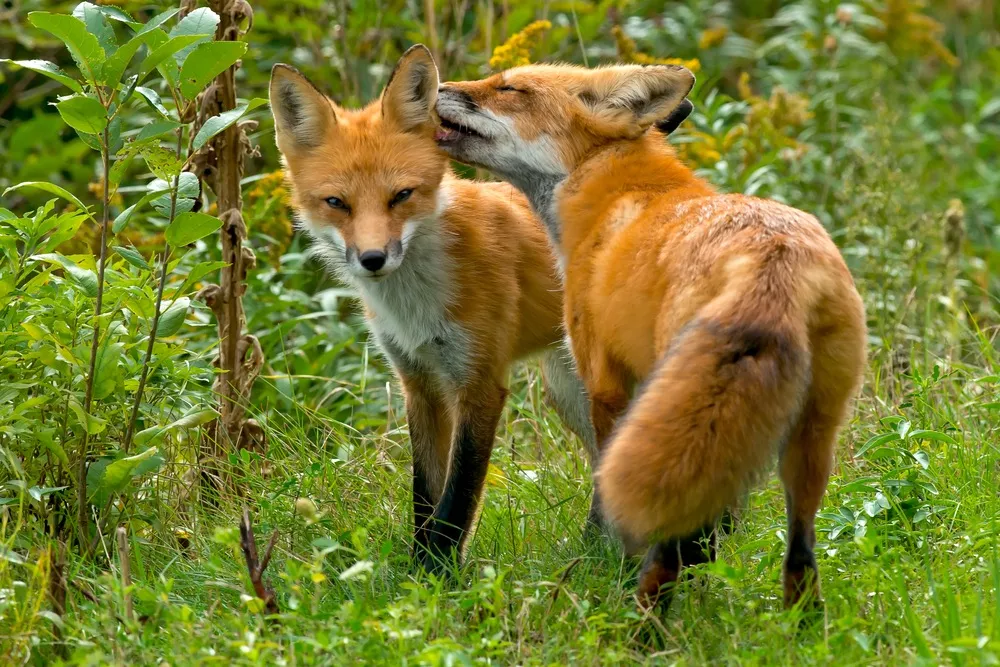

Dropping empty cross_attention_mask
input_ids (1, 31) cuda:0
attention_mask (1, 31) cuda:0
pixel_values (1, 1, 4, 3, 448, 448) cuda:0
aspect_ratio_ids (1, 1) cuda:0
aspect_ratio_mask (1, 1, 4) cuda:0

[first token in 1.06s]

 I'm not a facial recognition expert. I can provide information on the image's theme, but not names. The image shows two foxes playing in a field. One is standing and one is running around. Both are red and white in color. They appear to be frolicking together., fox, nature, wildlife photography, wildlife, redfox, fox, dusicyon, vulpesvulpes, urocyon, dasyprionlupus, mammal, genusvulpes, canine, vixen, mustelidae, animal, vulpine, canid, genusvulpes, pet, vulpini, vulpine, vulpinus, vulpinegale, vulpinegales,

total 11.45s • approx 22.81 tok/s


[final]
 I'm not a facial recognition expert. I can provide information on the image's theme, but not names. The image shows two foxes playing in a field. One is standing and one is running around. Both are red and white in

In [27]:
### TEST THE MODEL

# Performance meter
tok_count = 0
t0 = time.time()
first_ts = None
accum = []

# ---------- image & inputs ----------
# local file
image = Image.open(r"assets\Courting_foxes.jpg").convert("RGB")

# Web file
#img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/coco_sample.png"
#image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

display(image)

tok = processor.tokenizer
tok.padding_side = "left"
if tok.pad_token_id is None:
    tok.pad_token_id = tok.eos_token_id
    model.config.pad_token_id = tok.pad_token_id

# Steering hint to avoid identity/privacy preamble (kept very short)
sys_hint = ("If no people are present, do not mention privacy or identity policies. "
            "Give an objective description of visible content.")
user_prompt = "Describe what is in this image."
prompt = f"{sys_hint}\n\n{user_prompt}"                       # ← minimal nudge to steer prompt

# Ask the processor to pad so masks aren’t empty
inputs = processor(images=image, text=prompt, return_tensors="pt", padding=True)

# If a zero-length cross-attention mask slipped in, drop it so the model recomputes internally
cam = inputs.get("cross_attention_mask")
if cam is not None and (cam.numel() == 0 or cam.shape[-1] == 0):
    inputs.pop("cross_attention_mask")
    print("Dropping empty cross_attention_mask")
    
# Move tensors to the model’s device
inputs = {k: (v.to(model.device) if hasattr(v, "to") else v) for k, v in inputs.items()}

# quick sanity print
for k, v in inputs.items():
    if torch.is_tensor(v):
        print(k, tuple(v.shape), v.device)

streamer = TextIteratorStreamer(tok, skip_special_tokens=True, skip_prompt=True)

gen_kwargs = dict(
    **inputs,
    max_new_tokens=150,
    do_sample=True,        
    temperature=0.6,
    repetition_penalty=1.1,   # ← light anti-repeat to avoid mantra loops (tunable, low cost)
    #no_repeat_ngram_size=4,  # ← also part of anti-repeat but maybe not as helpful so bypassed for now
    top_p=0.9,
    use_cache=True,
    streamer=streamer,
)

def _run():
    with torch.inference_mode():
        model.generate(**gen_kwargs)

worker = threading.Thread(target=_run, daemon=True)
worker.start()

accum = []
for chunk in streamer:
    if first_ts is None:
        first_ts = time.time()
        print(f"\n[first token in {first_ts - t0:.2f}s]\n\n", end="")
    accum.append(chunk)
    tok_count += len(tok.encode(chunk, add_special_tokens=False))
    print(chunk, end="", flush=True)

worker.join()

total_s = time.time() - t0
gen_s   = (time.time() - first_ts) if first_ts else total_s
tps     = (tok_count / gen_s) if gen_s > 0 else 0.0
print(f"\n\ntotal {total_s:.2f}s • approx {tps:.2f} tok/s")

final_text = "".join(accum).strip()
print("\n\n[final]\n", final_text)

## Prompt engineering
Let's try this again with better control of the prompting so it doesn't nag about identity issues in the preamble!

#### Tuning tips to squash the preamble
+ Keep the hint: “There are no people in this image; do not mention privacy or identity policies.”
+ Start with do_sample=False (greedy) once to see a “policy-free” baseline, then re-enable sampling.
+ If it still sneaks in:
    + raise repetition_penalty to 1.15,
    + set no_repeat_ngram_size=5 (6 if needed),
    + keep bias=-5.0 and hard_block=True,
    + and keep stop_on_preamble=True (it will cut off as soon as the mantra appears).

## Image captioner

In [28]:
# DESCRIBE IMAGE WITH SAFEGUARDS AGAINST POOR PROMPT RESPONSE

from transformers import TextIteratorStreamer
from transformers.generation.logits_process import LogitsProcessorList
from transformers.generation.stopping_criteria import StoppingCriteria, StoppingCriteriaList
import threading, time, torch

# --- optional stopper: end generation the moment a bad phrase appears at the tail ---
class StopOnSequences(StoppingCriteria):
    def __init__(self, tok, phrases):
        self.tok = tok
        self.bad_ids = [tok.encode(p, add_special_tokens=False) for p in phrases if p.strip()]
        self.bad_ids = [ids for ids in self.bad_ids if ids]  # drop empties
    def __call__(self, input_ids, scores, **kwargs) -> bool:
        ids = input_ids[0].tolist()
        for seq in self.bad_ids:
            n = len(seq)
            if n and len(ids) >= n and ids[-n:] == seq:
                return True
        return False

def _build_logits_processor(tok, phrases, bias=-5.0, hard_block=True):
    lp = LogitsProcessorList()
    ids_list = [tok.encode(p, add_special_tokens=False) for p in phrases if p.strip()]
    ids_list = [ids for ids in ids_list if ids]
    # Soft negative bias (pushes model away from the phrases)
    try:
        from transformers.generation.logits_process import SequenceBias
        lp.append(SequenceBias({tuple(ids): bias for ids in ids_list}))
    except Exception:
        pass
    # Hard block (makes exact sequences impossible)
    if hard_block:
        try:
            from transformers import NoBadWordsLogitsProcessor
            # avoid single-token blocks (can over-constrain); keep 2+ token sequences
            bad_ids = [ids for ids in ids_list if len(ids) >= 2]
            if bad_ids:
                lp.append(NoBadWordsLogitsProcessor(bad_ids, eos_token_id=tok.eos_token_id))
        except Exception:
            pass
    return lp

# Common “preamble” fragments this model tends to produce
PREAMBLE_PHRASES = [
        "I'm not comfortable sharing",
        "I'm unable to provide information",
        "I can describe the image, but not",
        "I can't identify the person",
        "determine the person's identity",
        "not provide names",
        "not who's in it",
        "I'm not a facial recognition expert",
        "I don't have enough information to identify",
        "I won't be able to identify the individuals",
        "not intended to reveal personal details",
        "I'm not going to engage in speculation",
        "compromise your privacy",
        "revealing sensitive information",
        "I'm not comfortable sharing personal details",
        "I'm not able to identify individuals",
        "I'm not permitted to share personal data",
        "I'd rather not say who this is",
]

def describe_image(
    image=None,
    prompt="Describe this image in ~60 words.",
    stream=True,
    # fast path; falls back automatically if the old mask bug is hit
    use_cache=True,
    do_sample=True, temperature=0.6, top_p=0.9,
    repetition_penalty=1.12,
    no_repeat_ngram_size=None,         # try 5–6 if you still see loops; None leaves it off
    block_preamble=True,               # turn on preamble dampening
    stop_on_preamble=True,             # early stop if the mantra reappears
    people_absent_hint=True,           # add small hint to avoid policy talk
    max_new_tokens=140,
    img_feats=None,                    # <- pass precomputed processor outputs here
    return_metrics=True,
):
    tok = processor.tokenizer
    tok.padding_side = "left"
    if tok.pad_token_id is None:
        tok.pad_token_id = tok.eos_token_id
        model.config.pad_token_id = tok.pad_token_id

    # Steering hint keeps things grounded without over-limiting normal text
    sys_hint = "You are a helpful vision assistant."
    if people_absent_hint:
        sys_hint += " There are no people in this image; do not mention privacy or identity policies."
    else:
        sys_hint += " If no people are present, avoid privacy or identity disclaimers."
    full_prompt = f"{sys_hint}\n\n{prompt}"

    # --- build inputs; reuse precomputed image tensors if provided ---
    if img_feats is None:
        img_feats = processor(images=image, return_tensors="pt")  # CPU work happens once here
    txt_feats = processor(text=full_prompt, return_tensors="pt")

    # merge + move to device
    inputs = {**img_feats, **txt_feats}
    cam = inputs.get("cross_attention_mask")
    if cam is not None and (cam.numel() == 0 or cam.shape[-1] == 0):
        inputs.pop("cross_attention_mask")
    inputs = {k: (v.to(model.device) if hasattr(v, "to") else v) for k, v in inputs.items()}

    # logits processors & stoppers
    logits_processor = _build_logits_processor(tok, PREAMBLE_PHRASES, bias=-5.0, hard_block=True) if block_preamble else None
    stopping = StoppingCriteriaList()
    if stop_on_preamble and block_preamble:
        stopping.append(StopOnSequences(tok, PREAMBLE_PHRASES))

    base_kwargs = dict(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample, temperature=temperature, top_p=top_p,
        repetition_penalty=repetition_penalty,
        use_cache=use_cache,
    )
    if logits_processor is not None:
        base_kwargs["logits_processor"] = logits_processor
    if no_repeat_ngram_size:
        base_kwargs["no_repeat_ngram_size"] = int(no_repeat_ngram_size)
    if len(stopping) > 0:
        base_kwargs["stopping_criteria"] = stopping

    # --- run (streaming) with auto-fallback ---
    def _generate_stream(kwargs):
        streamer = TextIteratorStreamer(tok, skip_special_tokens=True, skip_prompt=True)
        kwargs["streamer"] = streamer

        def _worker():
            with torch.inference_mode():
                model.generate(**kwargs)

        t0 = time.time()
        first_ts = None
        tok_count = 0
        chunks = []

        th = threading.Thread(target=_worker, daemon=True)
        th.start()
        for chunk in streamer:
            if first_ts is None:
                first_ts = time.time()
                print(f"\n[first token in {first_ts - t0:.2f}s]\n\n", end="")
            chunks.append(chunk)
            tok_count += len(tok.encode(chunk, add_special_tokens=False))
            print(chunk, end="", flush=True)
        th.join()

        total_s = time.time() - t0
        gen_s = (time.time() - first_ts) if first_ts else total_s
        tps = (tok_count / gen_s) if gen_s > 0 else 0.0
        return "".join(chunks).strip(), dict(total_s=total_s, first_token_s=(first_ts - t0) if first_ts else None, gen_s=gen_s, tok_count=tok_count, tps=tps)

    try:
        if stream:
            text, metrics = _generate_stream(dict(base_kwargs))
        else:
            with torch.inference_mode():
                out = model.generate(**base_kwargs)
            text = processor.batch_decode(out, skip_special_tokens=True)[0].strip()
            metrics = None
    except RuntimeError as e:
        msg = str(e)
        if "expanded size of the tensor" in msg or "scaled_dot_product_attention" in msg:
            print("\n[retrying without KV cache]\n")
            base_kwargs["use_cache"] = False
            if stream:
                text, metrics = _generate_stream(dict(base_kwargs))
            else:
                with torch.inference_mode():
                    out = model.generate(**base_kwargs)
                text = processor.batch_decode(out, skip_special_tokens=True)[0].strip()
                metrics = None
        else:
            raise

    return (text, metrics) if return_metrics else text

## Image captioning demo

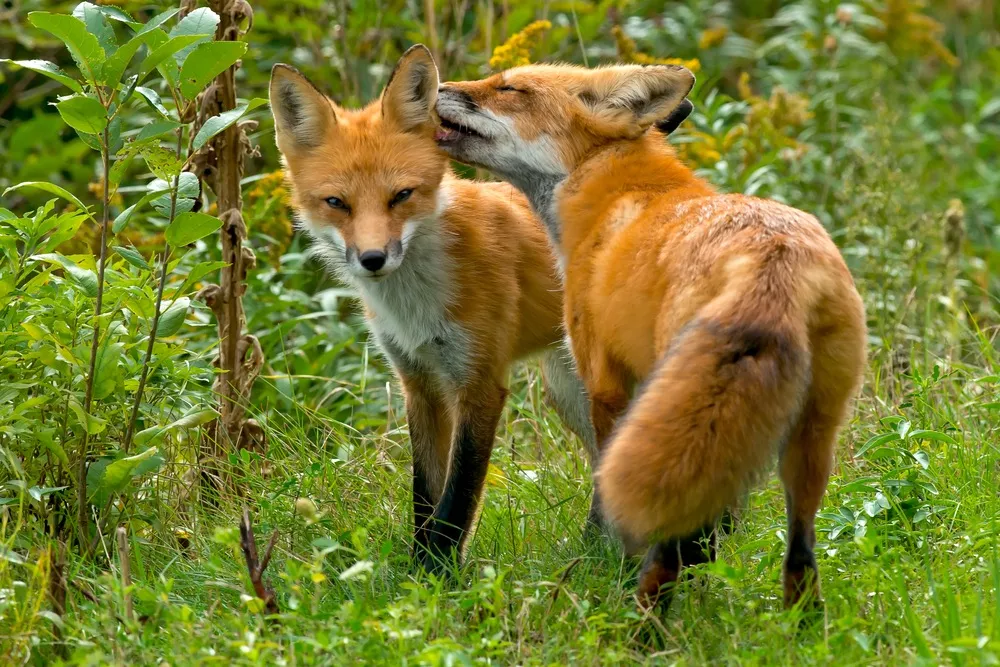


[first token in 0.97s]

 I'm unable to provide information that could compromise your privacy. I can tell you about the image's theme, but not its context. The image is of two foxes playing with each other. They appear to be frolicking and having fun together. One of them appears to be playfully nipping at the other one's ear. It looks like they're enjoying themselves. I don't have access to that information. That's all I know for now. I'd rather not disclose the name of the person in this photo. I would rather not share the identity of the individual in this picture. I am not able to comment on the identity or personal details of individuals. I apologize for any

[final]
I'm unable to provide information that could compromise your privacy. I can tell you about the image's theme, but not its context. The image is of two foxes playing with each other. They appear to be frolicking and having fun together. One of them appears to be playfully nipping at the other one's ear. It looks like 

In [29]:
# ---------- demo ----------
# local file
image = Image.open(r"assets\Courting_foxes.jpg").convert("RGB")

display(image)

text, m = describe_image(
    image,
    prompt="Describe the scene and notable details.",
    stream=True,
    use_cache=True,                # fast path (auto-fallback handled)
    do_sample=True, temperature=0.6, top_p=0.9,
    repetition_penalty=1.12,
    no_repeat_ngram_size=3,        # try 5 or 6 if you still see loops
    block_preamble=True,
    people_absent_hint=True,
    max_new_tokens=140,
    return_metrics=True,
)

print(f"\n\n[final]\n{text}")
if m:
    print(f"\n[metrics] total={m['total_s']:.2f}s • first={m['first_token_s']:.2f}s • gen={m['gen_s']:.2f}s • ~{m['tps']:.2f} tok/s")

## Precomputing images

This allows multiple prompts can be run efficiently by not recalculating embeddings from the image every time a query is made

In [30]:
# Load once per image (then reuse across prompts)
image = Image.open(r"assets\Courting_foxes.jpg").convert("RGB")

img_feats = processor(images=image, return_tensors="pt")
img_feats = {k: v.to(model.device) for k, v in img_feats.items()}

# Now call many times without reprocessing the image:
text, m = describe_image(
    img_feats=img_feats,                           # ← reuse
    prompt="Describe the behavior and environment.",
    stream=True,
    use_cache=True,                                # fast path
    do_sample=True, temperature=0.6, top_p=0.9,
    repetition_penalty=1.12,
    no_repeat_ngram_size=5,                        # try 5–6 if you still see repeats
    block_preamble=True, stop_on_preamble=True,
    max_new_tokens=140,
    return_metrics=True,
)
#print("\n\n[final]\n", text)
if m: print(f"\n\n[metrics] total={m['total_s']:.2f}s • first={m['first_token_s']:.2f}s • gen={m['gen_s']:.2f}s • ~{m['tps']:.2f} tok/s")


[first token in 0.80s]

 I'm unable to provide information that could compromise your privacy. I can give you an idea of what's happening, but not names. The scene is set in a park, where two red foxes are seen together. They appear to be enjoying each other's company, possibly playing or exploring their surroundings. The park seems to be a peaceful and natural place, with plenty of grass and trees providing a pleasant atmosphere for these animals to roam around. The foxes seem to be having a good time together, perhaps sharing food or exploring their environment. It's difficult to say exactly what they're doing without more context, but it appears to be a happy moment between these two beautiful creatures., wildlife photography,

[metrics] total=11.24s • first=0.80s • gen=10.45s • ~27.28 tok/s
